# 5. Neural Networks

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from prml import autodiff, bayesnet, nn

np.random.seed(1234)

## 5.1 Feed-forward Network Functions

In [2]:
def two_layer_network(n_input, n_hidden, n_output):
    return nn.Network(
        nn.layers.Dense(n_input, n_hidden, initializer=nn.initializers.TruncNormal(0, 1, -2, 2)),
        nn.layers.Tanh(),
        nn.layers.Dense(n_hidden, n_output, initializer=nn.initializers.TruncNormal(0, 1, -2, 2))
    )

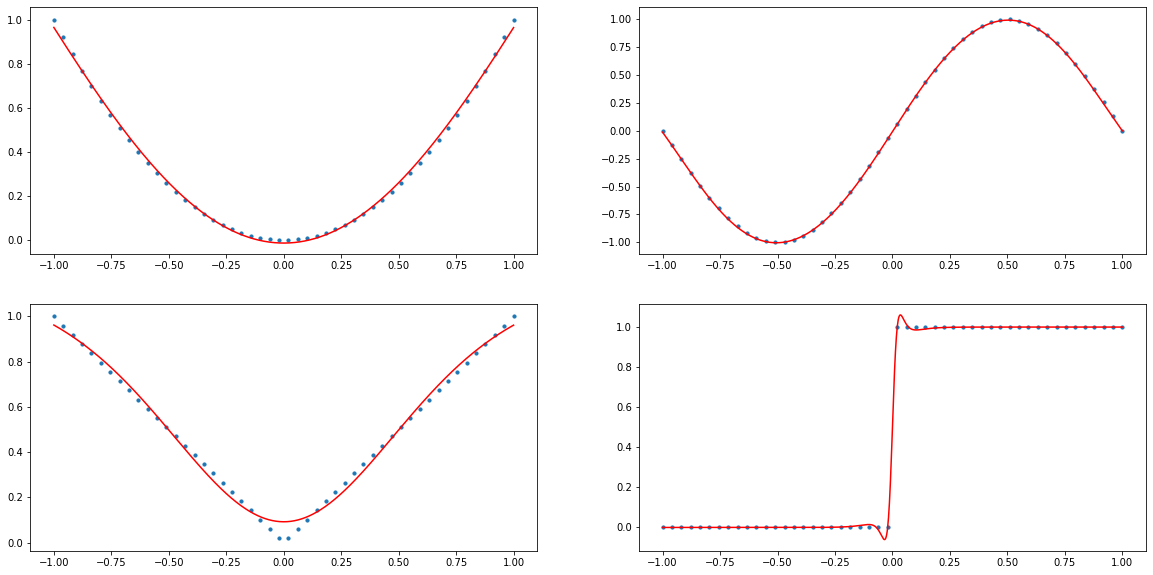

In [3]:
def create_toy_data(func, n=50):
    x = np.linspace(-1, 1, n)[:, None]
    return x, func(x)

def sinusoidal(x):
    return np.sin(np.pi * x)

def heaviside(x):
    return 0.5 * (np.sign(x) + 1)

func_list = [np.square, sinusoidal, np.abs, heaviside]
plt.figure(figsize=(20, 10))
x = np.linspace(-1, 1, 1000)[:, None]
for i, func, n_iter in zip(range(1, 5), func_list, [1000, 10000, 10000, 10000]):
    plt.subplot(2, 2, i)
    x_train, y_train = create_toy_data(func)
    model = two_layer_network(1, 3, 1)
    optimizer = autodiff.optimizer.Adam(model.parameter, 0.1)
    for _ in range(n_iter):
        loss = autodiff.square(y_train - model(x_train)).sum()
        optimizer.minimize(loss)
    y = model(x).value
    plt.scatter(x_train, y_train, s=10)
    plt.plot(x, y, color="r")
plt.show()

## 5.3 Error Backpropagation

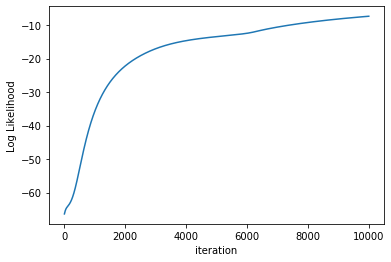

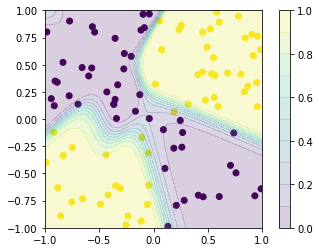

In [4]:
def create_toy_data():
    x = np.random.uniform(-1., 1., size=(100, 2))
    labels = np.prod(x, axis=1) > 0
    return x, labels.reshape(-1, 1)


x_train, y_train = create_toy_data()
model = two_layer_network(2, 4, 1)
optimizer = autodiff.optimizer.Adam(model.parameter, 1e-3)
history = []
for i in range(10000):
    logit = model(x_train)
    log_likelihood = autodiff.random.bernoulli_logpdf(y_train, logit).sum()
    optimizer.maximize(log_likelihood)
    history.append(log_likelihood.value)
    
plt.plot(history)
plt.xlabel("iteration")
plt.ylabel("Log Likelihood")
plt.show()
    
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T
y = autodiff.sigmoid(model(x)).value.reshape(100, 100)

levels = np.linspace(0, 1, 11)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.ravel())
plt.contourf(x0, x1, y, levels, alpha=0.2)
plt.colorbar()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')
plt.show()

## 5.5 Regularization in Neural Networks

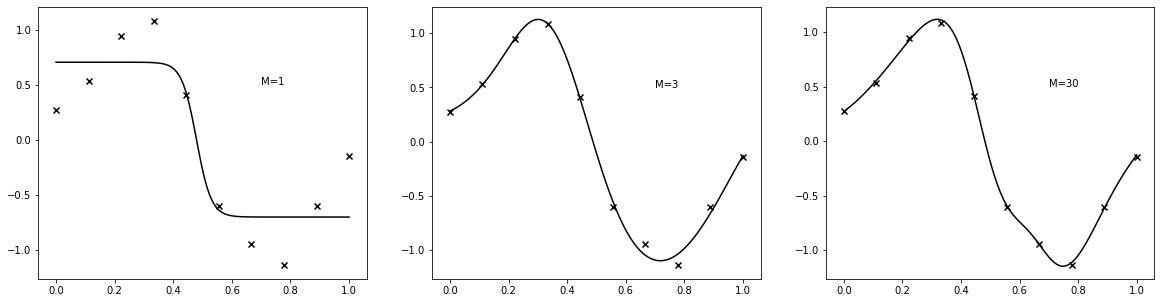

In [5]:
def create_toy_data(n=10):
    x = np.linspace(0, 1, n)[:, None]
    return x, np.sin(2 * np.pi * x) + np.random.normal(scale=0.25, size=(10, 1))


x_train, y_train = create_toy_data()
x = np.linspace(0, 1, 100)[:, None]

plt.figure(figsize=(20, 5))
for i, m in enumerate([1, 3, 30]):
    plt.subplot(1, 3, i + 1)
    model = two_layer_network(1, m, 1)
    optimizer = autodiff.optimizer.Adam(model.parameter, 0.1)
    for j in range(10000):
        y = model(x_train)
        optimizer.minimize(autodiff.square(y - y_train).sum())
        if j % 1000 == 0:
            optimizer.learning_rate *= 0.9
    y = model(x)
    plt.scatter(x_train.ravel(), y_train.ravel(), marker="x", color="k")
    plt.plot(x.ravel(), y.value.ravel(), color="k")
    plt.annotate("M={}".format(m), (0.7, 0.5))
plt.show()

In [6]:
class RegularizedRegressionNetwork(autodiff.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        with self.initialize():
            self.network = nn.Network(
                nn.layers.Dense(n_input, n_hidden, initializer=nn.initializers.TruncNormal(0, 1, -2, 2)),
                nn.layers.Tanh(),
                nn.layers.Dense(n_hidden, n_output, initializer=nn.initializers.TruncNormal(0, 1, -2, 2))
            )
        self.prior = bayesnet.Gaussian(mean=0, std=10)

    def __call__(self, x):
        return self.network(x)
    
    def log_prior(self):
        logp = 0
        for param in self.parameter.values():
            logp += self.prior.log_pdf(x=param)
        return logp

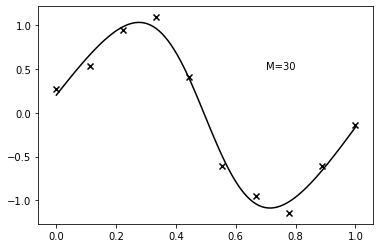

In [7]:
model = RegularizedRegressionNetwork(1, 30, 1)
optimizer = autodiff.optimizer.Adam(model.parameter, 0.1)
for i in range(10000):
    pred = model(x_train)
    log_posterior = -autodiff.square(pred - y_train).sum() + model.log_prior()
    optimizer.maximize(log_posterior)
    if i % 1000 == 0:
        optimizer.learning_rate *= 0.9
y = model(x).value
plt.scatter(x_train, y_train, marker="x", color="k")
plt.plot(x, y, color="k")
plt.annotate("M=30", (0.7, 0.5))
plt.show()

In [8]:
x, y = fetch_openml("mnist_784", return_X_y=True)

x = x / np.max(x, axis=1, keepdims=True)
x = x.reshape(-1, 28, 28, 1)
y = y.astype(np.int)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [9]:
def lenet():
    return nn.Network(
        nn.layers.Convolution2d(1, 20, 5),
        nn.layers.ReLU(),
        nn.layers.MaxPooling2d(),
        nn.layers.Convolution2d(20, 20, 5),
        nn.layers.ReLU(),
        nn.layers.MaxPooling2d(),
        nn.layers.Flatten(),
        nn.layers.Dense(4 * 4 * 20, 100),
        nn.layers.ReLU(),
        nn.layers.Dropout(),
        nn.layers.Dense(100, 10)
    )

In [10]:
model = lenet()
optimizer = autodiff.optimizer.Adam(model.parameter, 1e-3)

while True:
    indices = np.random.permutation(len(x_train))
    for index in range(0, len(x_train), 50):
        x_batch = x_train[indices[index: index + 50]]
        y_batch = y_train[indices[index: index + 50]]
        logit = model(x_batch)
        loss = autodiff.softmax_cross_entropy(y_batch, logit).mean()
        if optimizer.iter_count % 100 == 0:
            accuracy = accuracy_score(
                y_batch, np.argmax(logit.value, axis=-1)
            )
            print("step {:04d}".format(optimizer.iter_count), end=", ")
            print("accuracy {:.2f}".format(accuracy), end=", ")
            print("Loss {:g}".format(loss.value[0]))
        optimizer.minimize(loss)
        if optimizer.iter_count == 1000:
            break
    else:
        continue
    break

step 0000, accuracy 0.12, Loss 2.3
step 0100, accuracy 0.86, Loss 0.449597
step 0200, accuracy 0.82, Loss 0.613364
step 0300, accuracy 0.94, Loss 0.171714
step 0400, accuracy 0.96, Loss 0.315817
step 0500, accuracy 0.96, Loss 0.13263
step 0600, accuracy 0.98, Loss 0.0901302
step 0700, accuracy 0.96, Loss 0.113413
step 0800, accuracy 0.92, Loss 0.335112
step 0900, accuracy 0.98, Loss 0.13291


In [11]:
print("accuracy (test):", accuracy_score(np.argmax(model(x_test).value, axis=-1), y_test))

accuracy (test): 0.9491428571428572


## 5.6 Mixture Density Networks

In [12]:
def create_toy_data(func, n=300):
    t = np.random.uniform(size=(n, 1))
    x = func(t) + np.random.uniform(-0.05, 0.05, size=(n, 1))
    return x, t

def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)

def sample(x, t, n=None):
    assert len(x) == len(t)
    N = len(x)
    if n is None:
        n = Nt
    indices = np.random.choice(N, n, replace=False)
    return x[indices], t[indices]

x_train, y_train = create_toy_data(func)

In [13]:
class MixtureDensityNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_components):
        super().__init__()
        self.n_components = n_components
        initializer = nn.initializers.TruncNormal(0, 1, -2, 2)
        with self.initialize():
            self.w1 = initializer((n_input, n_hidden))
            self.b1 = autodiff.zeros(n_hidden)
            self.w2c = initializer((n_hidden, n_components))
            self.b2c = autodiff.zeros(n_components)
            self.w2m = initializer((n_hidden, n_components))
            self.b2m = autodiff.zeros(n_components)
            self.w2s = initializer((n_hidden, n_components))
            self.b2s = autodiff.zeros(n_components)

    def __call__(self, x):
        h = autodiff.tanh(x @ self.w1 + self.b1)
        coef = autodiff.softmax(h @ self.w2c + self.b2c)
        mean = h @ self.w2m + self.b2m
        std = autodiff.exp(h @ self.w2s + self.b2s)
        return coef, mean, std
    
def gaussian_mixture_pdf(x, coef, mu, std):
    gauss = (
        autodiff.exp(-0.5 * autodiff.square((x - mu) / std))
        / std / np.sqrt(2 * np.pi)
    )
    return (coef * gauss).sum(axis=-1)

In [14]:
model = MixtureDensityNetwork(1, 5, 3)
optimizer = autodiff.optimizer.Adam(model.parameter, 1e-4)

for i in range(30000):
    coef, mean, std = model(x_train)
    log_likelihood = autodiff.log(gaussian_mixture_pdf(y_train, coef, mean, std)).sum()
    optimizer.maximize(log_likelihood)

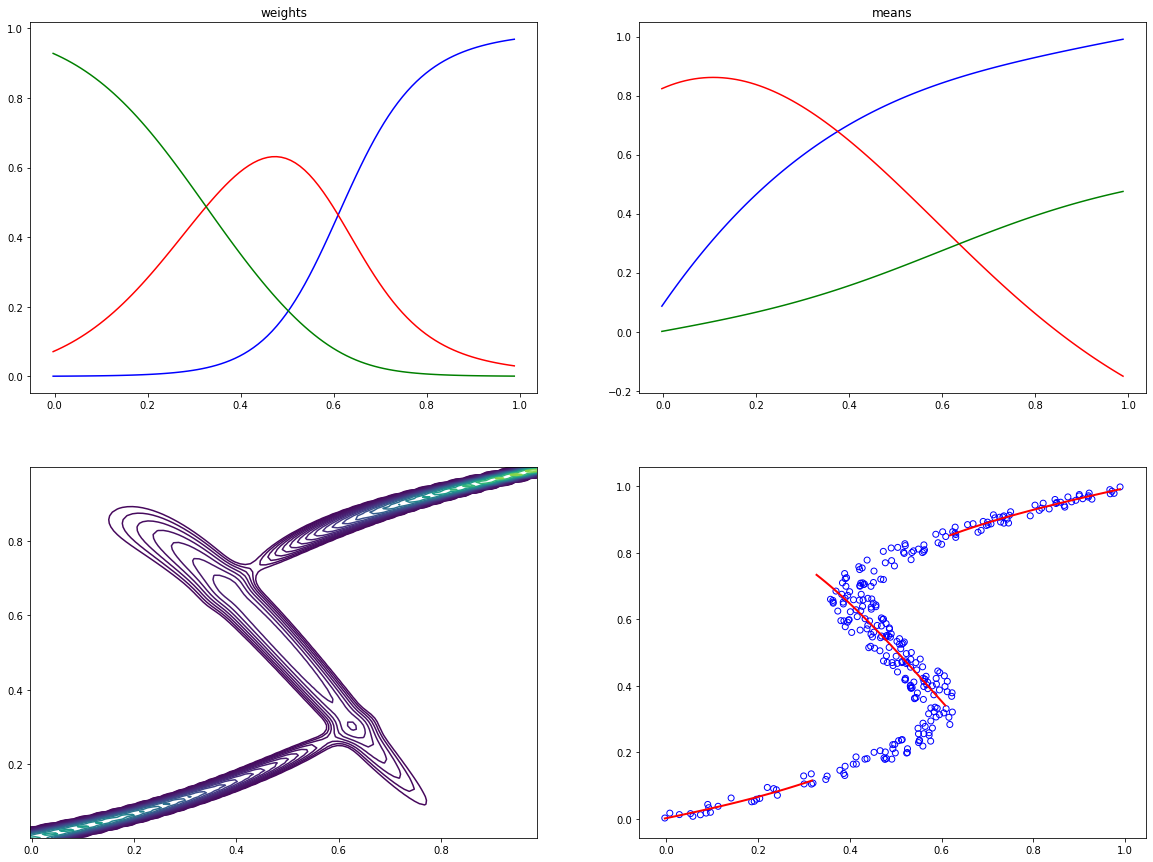

In [15]:
x = np.linspace(x_train.min(), x_train.max(), 100)[:, None]
y = np.linspace(y_train.min(), y_train.max(), 100)[:, None, None]
coef, mean, std = model(x)

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(x[:, 0], coef.value[:, 0], color="blue")
plt.plot(x[:, 0], coef.value[:, 1], color="red")
plt.plot(x[:, 0], coef.value[:, 2], color="green")
plt.title("weights")

plt.subplot(2, 2, 2)
plt.plot(x[:, 0], mean.value[:, 0], color="blue")
plt.plot(x[:, 0], mean.value[:, 1], color="red")
plt.plot(x[:, 0], mean.value[:, 2], color="green")
plt.title("means")

plt.subplot(2, 2, 3)
proba = gaussian_mixture_pdf(y, coef, mean, std).value
levels_log = np.linspace(0, np.log(proba.max()), 21)
levels = np.exp(levels_log)
levels[0] = 0
xx, yy = np.meshgrid(x.ravel(), y.ravel())
plt.contour(xx, yy, proba.reshape(100, 100), levels)
plt.xlim(x_train.min(), x_train.max())
plt.ylim(y_train.min(), y_train.max())

plt.subplot(2, 2, 4)
argmax = np.argmax(coef.value, axis=1)
for i in range(3):
    indices = np.where(argmax == i)[0]
    plt.plot(x[indices, 0], mean.value[(indices, np.zeros_like(indices) + i)], color="r", linewidth=2)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b")
plt.show()

## 5.7 Bayesian Neural Networks

In [16]:
x_train, y_train = make_moons(n_samples=500, noise=0.2)
y_train = y_train[:, None]

In [17]:
classifier = nn.Network(
    nn.layers.DenseBayesian(2, 5),
    nn.layers.Tanh(),
    nn.layers.DenseBayesian(5, 5),
    nn.layers.Tanh(),
    nn.layers.DenseBayesian(5, 1),
    nn.layers.Sigmoid()
)

In [18]:
optimizer = autodiff.optimizer.Adam(classifier.parameter, 0.1)
for i in range(10000):
    loss = autodiff.sigmoid_cross_entropy(y_train, classifier(x_train, -1)).sum() + classifier.loss()
    optimizer.minimize(loss)
    if i % 1000 == 0:
        print(f"step {i:5}, Loss {loss.value[0]}")

step     0, Loss 677.7535400390625
step  1000, Loss 235.45291137695312
step  2000, Loss 151.04324340820312
step  3000, Loss 123.84223937988281
step  4000, Loss 231.50376892089844
step  5000, Loss 135.31936645507812
step  6000, Loss 157.5681610107422
step  7000, Loss 124.13248443603516
step  8000, Loss 122.63318634033203
step  9000, Loss 121.86400604248047


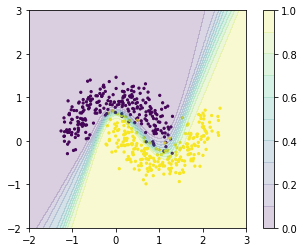

In [19]:
x_grid = np.mgrid[-2:3:100j, -2:3:100j]
x1, x2 = x_grid[0], x_grid[1]
x_grid = x_grid.reshape(2, -1).T

y = np.mean([classifier(x_grid).value.reshape(100, 100) for _ in range(10)], axis=0)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.ravel(), s=5)
plt.contourf(x1, x2, y, np.linspace(0, 1, 11), alpha=0.2)
plt.colorbar()
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()